# Agents' goal benchmark test
> Test whether a new version of a Multi-Agent System is performing better or not than its previous versions using user-defined goals

- toc: false
- badges: true
- comments: true
- author: Cleber Jorge Amaral
- categories: [comparison, jupyter]
- image: images/goal-benchmark-test.png

In [1]:
#hide
import numpy as np
import pandas as pd 
from scipy import stats

In [2]:
#hide
#DB_ADDR = "./" # use it if your file was uploaded manually to colab
DB_ADDR = "http://191.36.8.45:8080/" # using file served by nginx
url = DB_ADDR + "matches.csv"
src = pd.read_csv(url, sep='\t', dtype=str)

In [3]:
#hide
def maximization(a, b):
    return a > b
def minimization(a, b):
    return a < b

formulae = {
    'taskSubmitted':lambda a, b: maximization(a, b),
    'restarted_lost':lambda a, b: minimization(a, b),
    'restarted_noact':lambda a, b: minimization(a, b),
    'excessive_delay':lambda a, b: minimization(a, b)
}

def goal_formulae(goal):
    return formulae.get(goal,"Invalid formula")

def get_goals():
    return list(formulae.keys())

In [4]:
#hide_input
print("The following goals are set:")
import inspect
for goal in get_goals():
    print(inspect.getsource(goal_formulae(goal)), end="")

The following goals are set:
    'taskSubmitted':lambda a, b: maximization(a, b),
    'restarted_lost':lambda a, b: minimization(a, b),
    'restarted_noact':lambda a, b: minimization(a, b),
    'excessive_delay':lambda a, b: minimization(a, b)


In [5]:
#hide_input
tiny_sample_size = 15
small_sample_size = 30
good_sample_size = 40
print("For statistical tests the following threasholds are set:")
print("\ttiny_sample_size = 15 - t-test should be used")
print("\tsmall_sample_size = 30 - z-test can be used")
print("\tgood_sample_size = 40 - sample distribution do not need to be normal")
print("\tSource: Larson and Farber Moore; Notz and Fligner, see Using the t Procedures")

For statistical tests the following threasholds are set:
	tiny_sample_size = 15 - t-test should be used
	small_sample_size = 30 - z-test can be used
	good_sample_size = 40 - sample distribution do not need to be normal
	Source: Larson and Farber Moore; Notz and Fligner, see Using the t Procedures


In [6]:
#hide
def extract_data_by_event(event):
    extracted_df = pd.DataFrame({'version':[], 'indicator':[], 'value':[]})

    rid_list = src['rid'].unique()
    for rid in rid_list:
        if "B" not in rid:
            count_event = len(src[(src['event'] == event) & (src['rid'] == rid)].index)
            s = pd.Series([src[(src['rid'] == rid)].version.unique()[0], event, count_event], index=['version', 'indicator', 'value'])
            extracted_df = extracted_df.append(s, ignore_index=True)

    return extracted_df

In [7]:
#hide
def is_normal_distribution(version, df, alpha):
    from scipy.stats import norm
    versions_list = df['version'].unique()

    if (df[df['version'] == versions_list[version]].value.size < good_sample_size):
        W, shp_value = stats.shapiro(df[df['version'] == versions_list[version]].value)
        if shp_value >= alpha:
            return True
        else:
            return False
    else:
        return True

In [8]:
#hide
def has_versions_to_compare(df):
    versions_list = df['version'].unique()
    if not versions_list.size >= 2:
        #print("It is necessary to have at least two versions to compare!")
        return False
    else:
        #for v in versions_list:
        #  print(v," : sample size =",df[df['version'] == v].value.size)
        return True

In [9]:
#hide
def print_distribution(version,df):
    versions_list = df['version'].unique()
    data = df[df['version'] == versions_list[version]].value
    import matplotlib.pyplot as plt
    plt.figure(1)
    plt.subplot(211)
    mu, sigma = data.mean(), np.std(data, ddof=1) # mean and standard deviation
    counts, bins = np.histogram(data)
    plt.hist(bins[:-1], bins, weights=counts)
    plt.plot(bins[:-1]+(bins[1]-bins[0])/2, counts, linewidth=2, color='r')
    plt.subplot(212)
    plt.boxplot(data, vert=False)
    plt.show()
    return

In [10]:
#hide
def ztest(a, b):
    from numpy import sqrt, abs, round
    from scipy.stats import norm
    ma, mb = a.mean(), b.mean()
    sda, sdb = a.std(), b.std()
    na, nb = a.shape[0], b.shape[0]
    standard_error = sqrt(sda**2/na + sdb**2/nb)
    z = (ma - mb)/standard_error
    pvalue = 2*(1 - norm.cdf(abs(z)))
    return z, pvalue

In [11]:
#hide
# If sample size is at least 30 do z-test, otherwise do t-test
def versions_are_different(previous_version, new_version, df, alpha):
    if (df[df['version'] == versions_list[previous_version]].value.size >= 30 and df[df['version'] == versions_list[new_version]].value.size >= 30):
        z_stats, zp_value = ztest(df[df['version'] == versions_list[previous_version]].value,df[df['version'] == versions_list[new_version]].value)
        import matplotlib.pyplot as plt
        plt.hist(df[df['version'] == versions_list[previous_version]].value, density=True, bins=12)
        plt.hist(df[df['version'] == versions_list[new_version]].value, density=True, bins=12)
        plt.show()
        #print("z-statistic:",z_stats,"p-value:",zp_value)
        #print("pre mean:",df[df['version'] == versions_list[previous_version]].value.mean(),"new mean:",df[df['version'] == versions_list[new_version]].value.mean())
        if abs(zp_value) < (alpha / 2): # Two tailed: alpha/2
            return True
        else:
            return False
    else:
        t_stats, tp_value = stats.ttest_ind(df[df['version'] == versions_list[previous_version]].value,df[df['version'] == versions_list[new_version]].value)
        import matplotlib.pyplot as plt
        plt.hist(df[df['version'] == versions_list[previous_version]].value, density=True, bins=12)
        plt.hist(df[df['version'] == versions_list[new_version]].value, density=True, bins=12)
        plt.show()
        #print("t-statistic:",t_stats,"p-value:",tp_value)
        #print("pre mean:",df[df['version'] == versions_list[previous_version]].value.mean(),"new mean:",df[df['version'] == versions_list[new_version]].value.mean())
        if abs(tp_value) < (alpha / 2): # Two tailed: alpha/2
            return True
        else:
            return False

In [12]:
#hide
# If sample size is at least 30 do z-test, otherwise do t-test
def compare_versions(previous_version, new_version, df, goal):
    pre_value = df[df['version'] == versions_list[previous_version]].value.sum() / df[df['version'] == versions_list[previous_version]].value.size
    new_value = df[df['version'] == versions_list[new_version]].value.sum() / df[df['version'] == versions_list[new_version]].value.size
    if goal_formulae(goal)(new_value, pre_value):
        return True, pre_value, new_value
    else:
        return False, pre_value, new_value

## Testing each goal comparing new version against each previous version
> Check if the new version is performing better each goal according to the goal's optimization objective (maximization or minimization). The distribution of data of the new version and each previous version must be normal and they need to present evidence of difference in order to answer whether the new version is better or not than each of its previous versions.

Comparing goal: taskSubmitted...


  taskSubmitted (0.14): New version data is comparable!


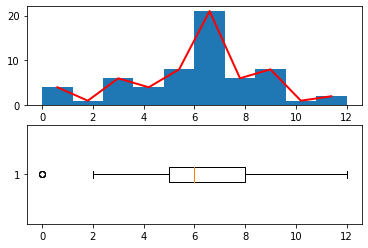

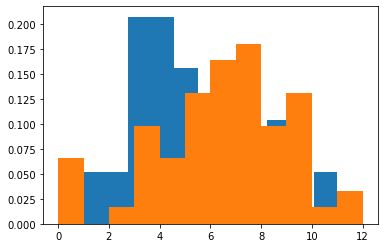

  taskSubmitted (0.14 vs 0.12.1): There is no evidence of difference!




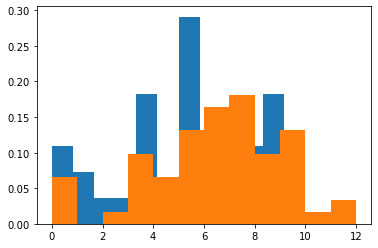

  taskSubmitted (0.14 vs 0.13): There is no evidence of difference!




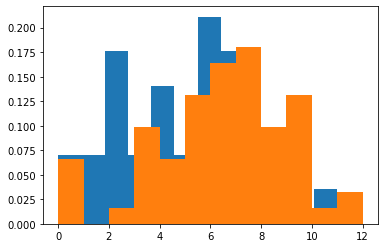

  taskSubmitted (0.14 vs 0.12): The new version is BETTER (6.0) than the previous (4.6)


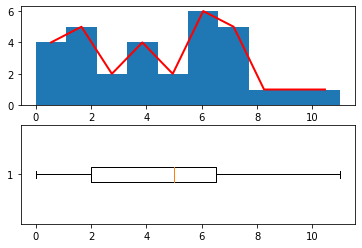

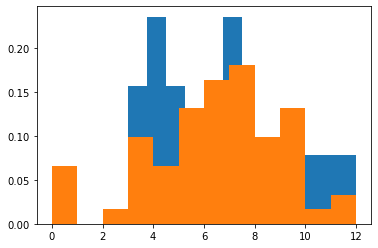

  taskSubmitted (0.14 vs 0.11): There is no evidence of difference!




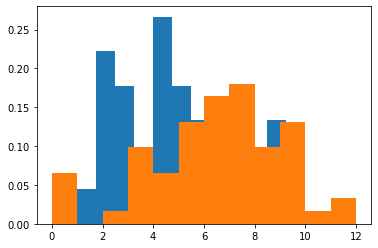

  taskSubmitted (0.14 vs 0.10): There is no evidence of difference!




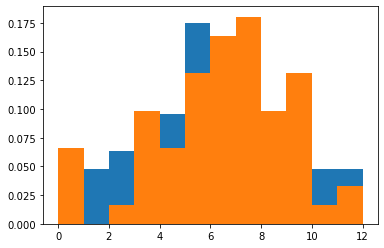

  taskSubmitted (0.14 vs 0.9): There is no evidence of difference!




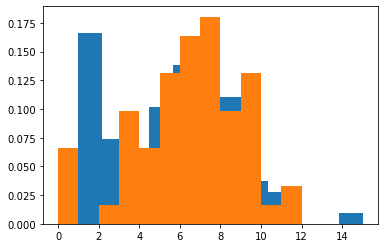

  taskSubmitted (0.14 vs 0.8): There is no evidence of difference!




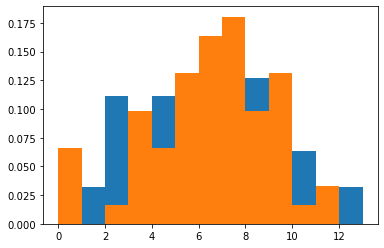

  taskSubmitted (0.14 vs 0.7): There is no evidence of difference!




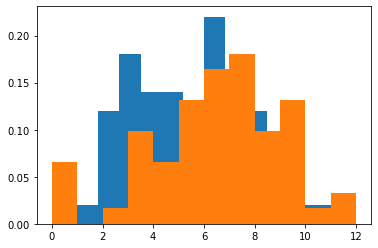

  taskSubmitted (0.14 vs 0.6): There is no evidence of difference!




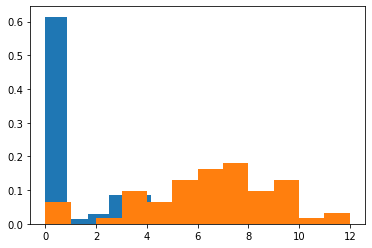

  taskSubmitted (0.14 vs 0.5): The new version is BETTER (6.0) than the previous (2.6)


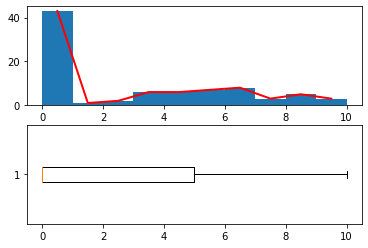

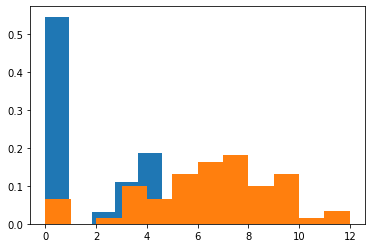

  taskSubmitted (0.14 vs 0.4): The new version is BETTER (6.0) than the previous (2.5)


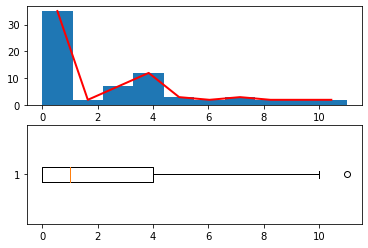

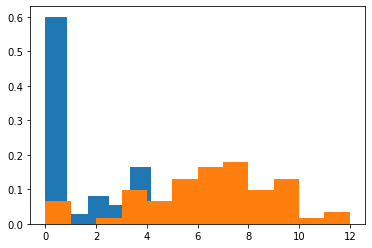

  taskSubmitted (0.14 vs 0.3): The new version is BETTER (6.0) than the previous (2.3)


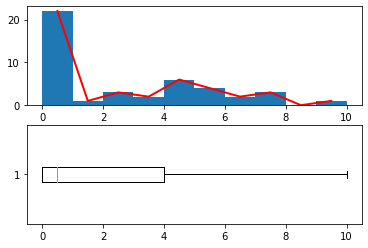

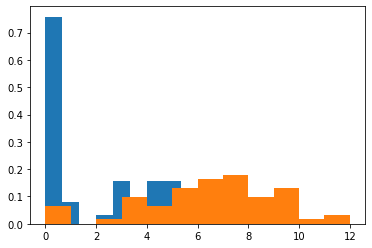

  taskSubmitted (0.14 vs 0.2): The new version is BETTER (6.0) than the previous (2.0)


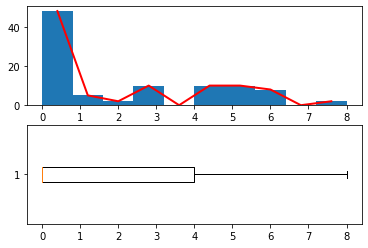

  taskSubmitted (0.14 vs 0.1): Data of previous version is not normally distributed.


Comparing goal: restarted_lost...


  restarted_lost (0.14): New version data is comparable!


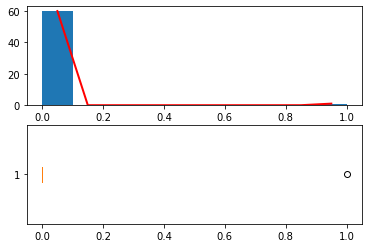

/home/cleber/.local/lib/python3.9/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


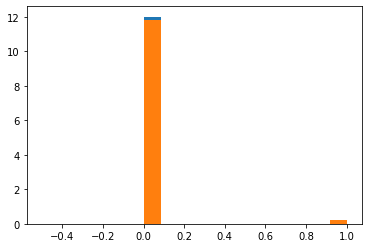

  restarted_lost (0.14 vs 0.12.1): There is no evidence of difference!




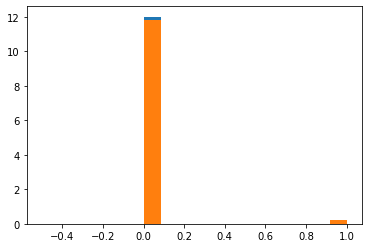

  restarted_lost (0.14 vs 0.13): There is no evidence of difference!




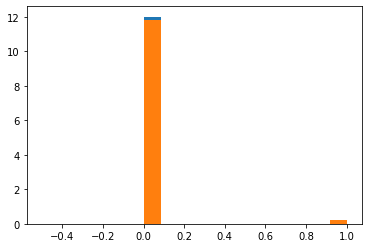

  restarted_lost (0.14 vs 0.12): There is no evidence of difference!


  restarted_lost (0.14 vs 0.11): Data of previous version is not normally distributed.




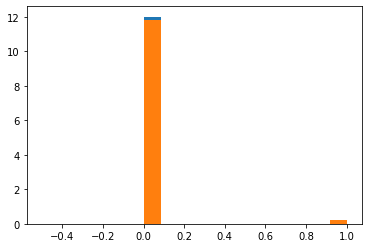

  restarted_lost (0.14 vs 0.10): There is no evidence of difference!




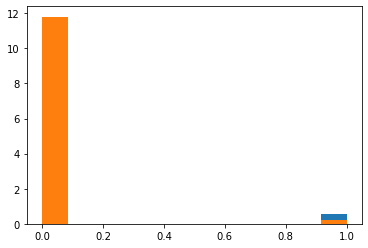

  restarted_lost (0.14 vs 0.9): There is no evidence of difference!




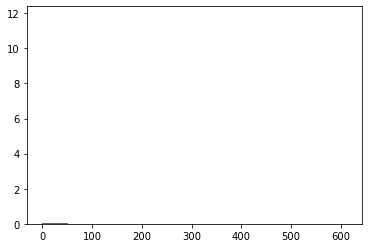

  restarted_lost (0.14 vs 0.8): The new version is BETTER (0.0) than the previous (26.6)


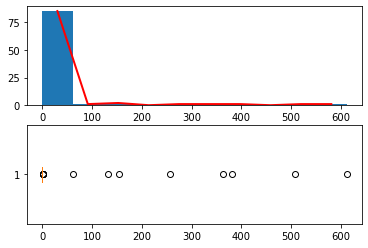

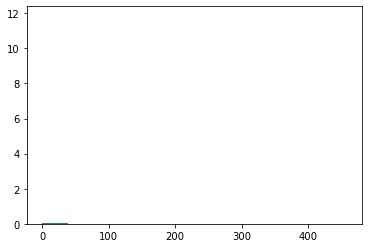

  restarted_lost (0.14 vs 0.7): There is no evidence of difference!




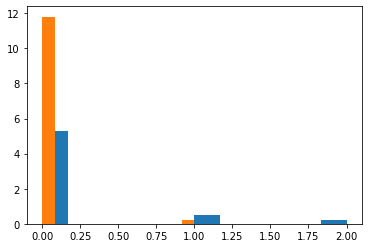

  restarted_lost (0.14 vs 0.6): There is no evidence of difference!




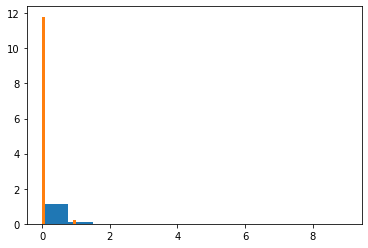

  restarted_lost (0.14 vs 0.5): The new version is BETTER (0.0) than the previous (0.4)


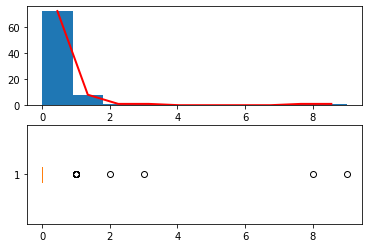

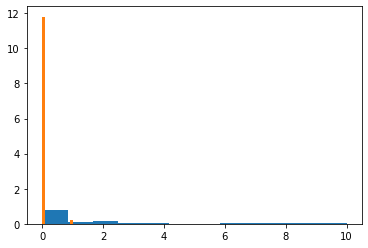

  restarted_lost (0.14 vs 0.4): The new version is BETTER (0.0) than the previous (1.2)


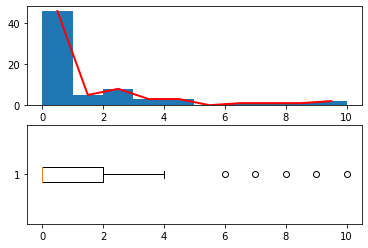

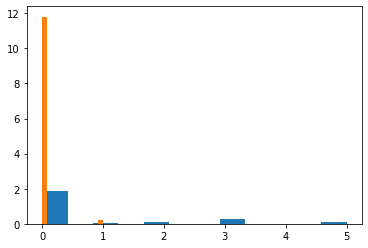

  restarted_lost (0.14 vs 0.3): The new version is BETTER (0.0) than the previous (0.7)


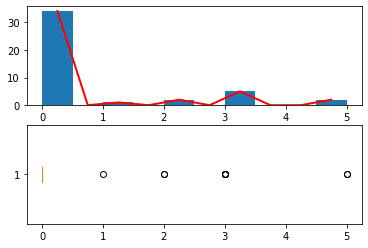

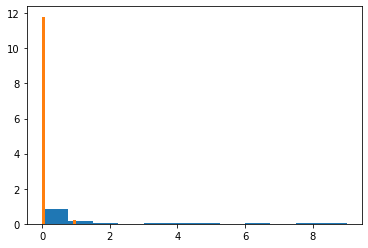

  restarted_lost (0.14 vs 0.2): The new version is BETTER (0.0) than the previous (1.3)


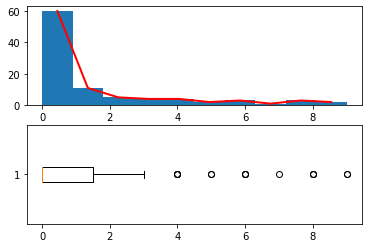

  restarted_lost (0.14 vs 0.1): Data of previous version is not normally distributed.


Comparing goal: restarted_noact...


  restarted_noact (0.14): New version data is comparable!


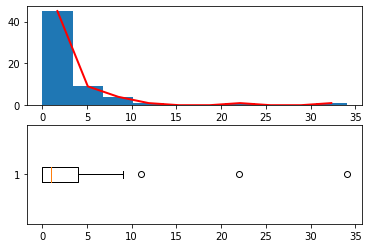

  restarted_noact (0.14 vs 0.12.1): Data of previous version is not normally distributed.


  restarted_noact (0.14 vs 0.13): Data of previous version is not normally distributed.


  restarted_noact (0.14 vs 0.12): Data of previous version is not normally distributed.


  restarted_noact (0.14 vs 0.11): Data of previous version is not normally distributed.


  restarted_noact (0.14 vs 0.10): Data of previous version is not normally distributed.




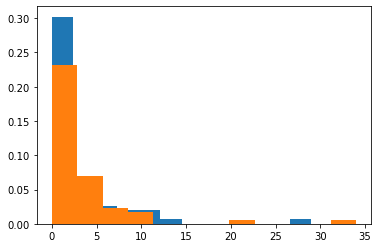

  restarted_noact (0.14 vs 0.9): There is no evidence of difference!




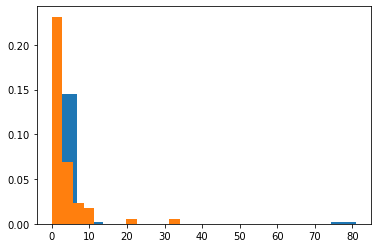

  restarted_noact (0.14 vs 0.8): There is no evidence of difference!




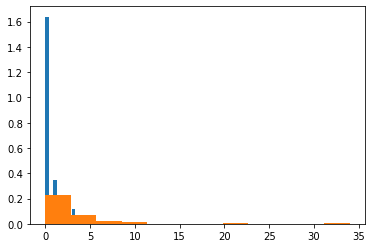

  restarted_noact (0.14 vs 0.7): The new version is WORST (3.0) than the previous (0.6)


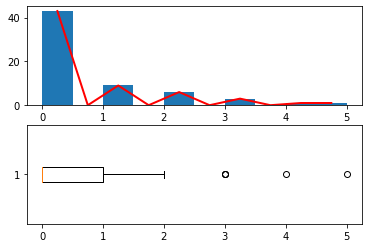

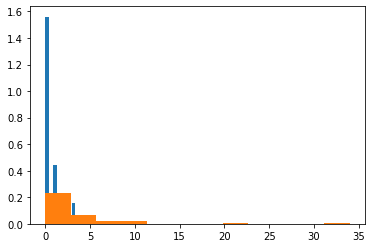

  restarted_noact (0.14 vs 0.6): The new version is WORST (3.0) than the previous (0.7)


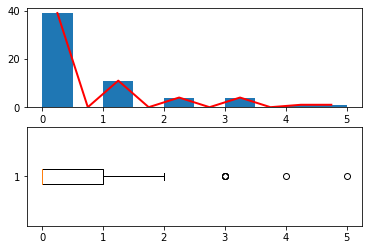

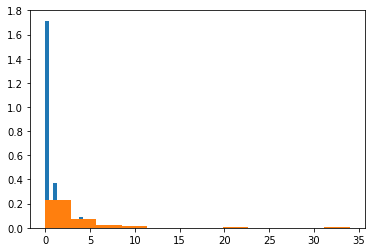

  restarted_noact (0.14 vs 0.5): The new version is WORST (3.0) than the previous (0.5)


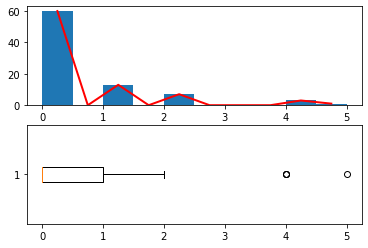

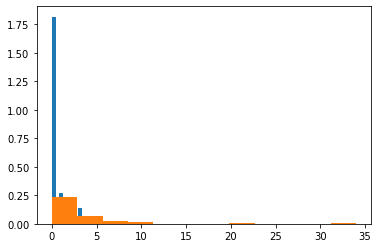

  restarted_noact (0.14 vs 0.4): The new version is WORST (3.0) than the previous (0.5)


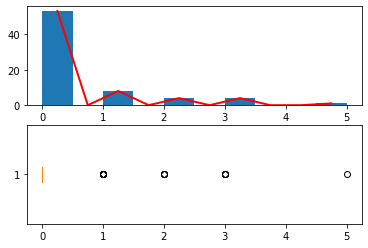

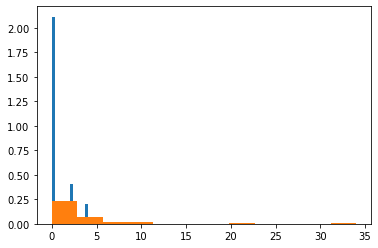

  restarted_noact (0.14 vs 0.3): The new version is WORST (3.0) than the previous (0.7)


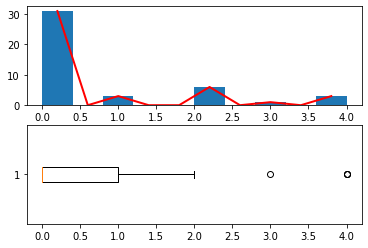

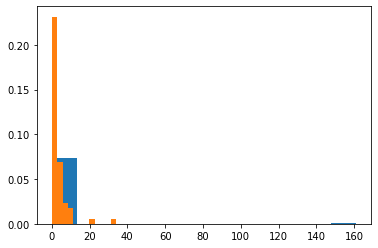

  restarted_noact (0.14 vs 0.2): There is no evidence of difference!


  restarted_noact (0.14 vs 0.1): Data of previous version is not normally distributed.


Comparing goal: excessive_delay...


  excessive_delay (0.14): New version data is comparable!


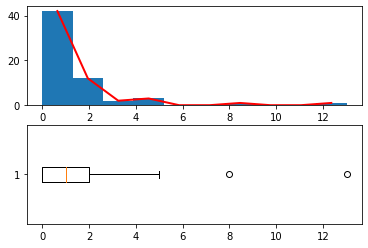

  excessive_delay (0.14 vs 0.12.1): Data of previous version is not normally distributed.


  excessive_delay (0.14 vs 0.13): Data of previous version is not normally distributed.


  excessive_delay (0.14 vs 0.12): Data of previous version is not normally distributed.


  excessive_delay (0.14 vs 0.11): Data of previous version is not normally distributed.


  excessive_delay (0.14 vs 0.10): Data of previous version is not normally distributed.




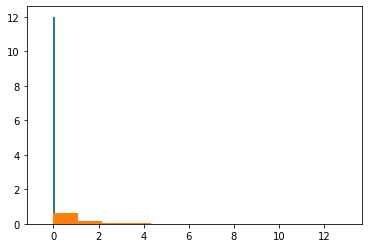

  excessive_delay (0.14 vs 0.9): The new version is WORST (1.5) than the previous (0.0)


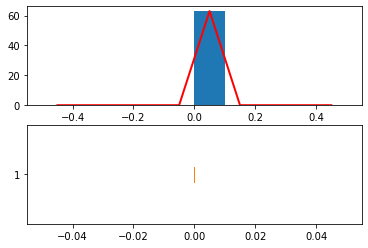

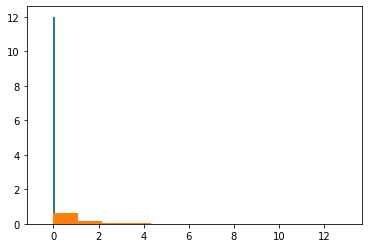

  excessive_delay (0.14 vs 0.8): The new version is WORST (1.5) than the previous (0.0)


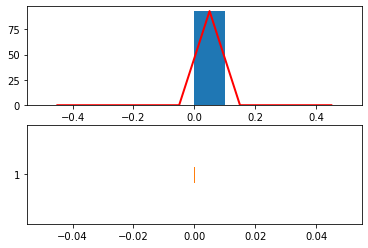

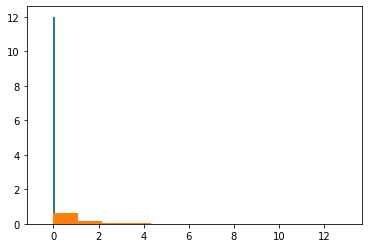

  excessive_delay (0.14 vs 0.7): The new version is WORST (1.5) than the previous (0.0)


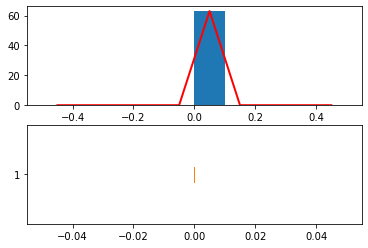

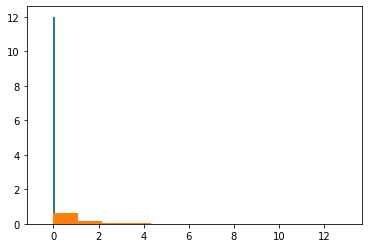

  excessive_delay (0.14 vs 0.6): The new version is WORST (1.5) than the previous (0.0)


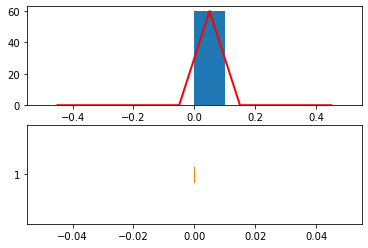

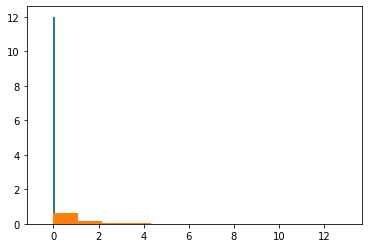

  excessive_delay (0.14 vs 0.5): The new version is WORST (1.5) than the previous (0.0)


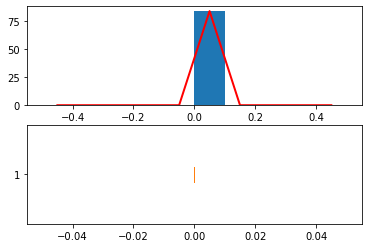

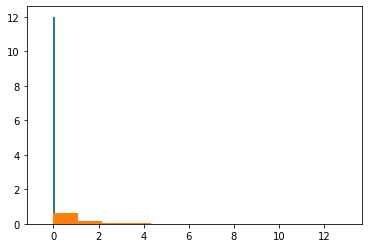

  excessive_delay (0.14 vs 0.4): The new version is WORST (1.5) than the previous (0.0)


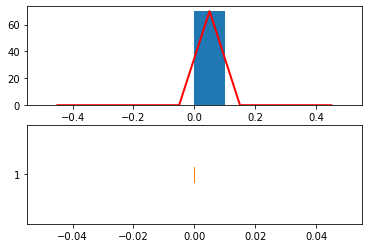

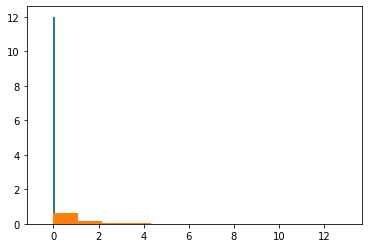

  excessive_delay (0.14 vs 0.3): The new version is WORST (1.5) than the previous (0.0)


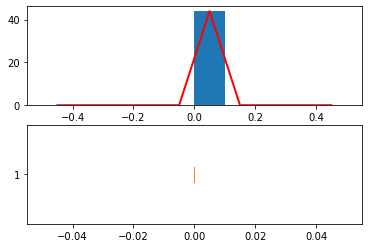

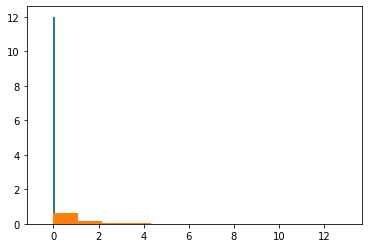

  excessive_delay (0.14 vs 0.2): The new version is WORST (1.5) than the previous (0.0)


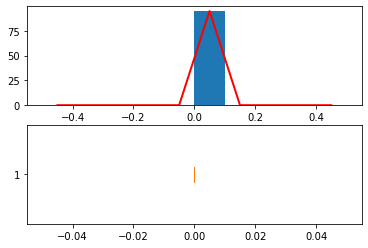

/home/cleber/.local/lib/python3.9/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


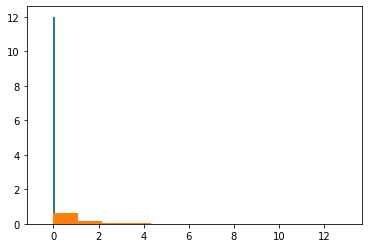

  excessive_delay (0.14 vs 0.1): The new version is WORST (1.5) than the previous (0.0)


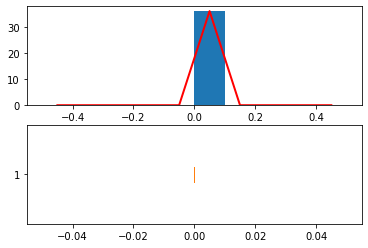

In [13]:
#hide_input
new_version = -1
alpha_normal = 0.05
alpha_compare = 0.05

for goal in get_goals():
    print("Comparing goal:",goal+"...")
    print("\n")
    
    df = extract_data_by_event(goal)

    versions_list = df['version'].unique()

    if not has_versions_to_compare(df):
        print("  "+goal+": It is necessary to have at least two versions to compare!")
    else:
        if is_normal_distribution(new_version, df, alpha_normal):
            print("  "+goal+" ("+str(versions_list[new_version])+"): New version data is comparable!")
            print_distribution(new_version,df)
            
            for previous_version in range(2, len(versions_list)+1):
                if is_normal_distribution(-previous_version, df, alpha_normal):
                    if versions_are_different(-previous_version, new_version, df, alpha_compare):
                        better, pre_value, new_value = compare_versions(-previous_version, new_version, df, goal)
                        if better:
                            print("  "+goal+" ("+str(versions_list[new_version]),"vs",str(versions_list[-previous_version])+"): The new version is BETTER ("+str(round(new_value,1))+") than the previous ("+str(round(pre_value,1))+")")
                        else:
                            print("  "+goal+" ("+str(versions_list[new_version]),"vs",str(versions_list[-previous_version])+"): The new version is WORST ("+str(round(new_value,1))+") than the previous ("+str(round(pre_value,1))+")")
                        print_distribution(-previous_version, df) 
                    else:
                        print("  "+goal+" ("+str(versions_list[new_version]),"vs",str(versions_list[-previous_version])+"): There is no evidence of difference!")
                        print("\n")
                else:
                    print("  "+goal+" ("+str(versions_list[new_version]),"vs",str(versions_list[-previous_version])+"): Data of previous version is not normally distributed.")
                    print("\n")
        else:
            print("  "+goal+" ("+str(versions_list[new_version])+"): The new version does not present a normal distribution!")
            print_distribution(new_version,df)

Developed by [Cleber Jorge Amaral](https://cleberjamaral.github.io/).

Sources:
* [Shapiro-Wilk test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
* David S. Moore, William I. Notz, Michael A. Fligner. The Basic Practice of Statistics. 6th Edition. W. H. Freeman (2011)
* Ron Larson and Betsy Farber. Elementary Statistics Picturing the World. 5th Edition. Prentice Hall (2012)